# Predicting Medical Insurance Charges with Regression

**Name**: David Rodriguez-Mayorquin 
**Date**: March 26, 2025. 

## Introduction

Intro

-


## 1. Import and Inspect the Data


In [37]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures


# 1.1 
# Load the dataset
df = pd.read_csv("data/insurance.csv")

# Show the first 10 rows
df.head(10)

# 1.2 
# Check for missing values and display summary statistics.
print("\nMissing values in each column:")
print(df.isnull().sum())

# Summary statistics
print("\nSummary statistics:")
print(df.describe())






Missing values in each column:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Summary statistics:
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


**Reflection 1**:  
This dataset has 1,338 rows and 7 columns, there aren’t any missing values. The setup looks pretty clean, with numeric columns like age, BMI, and charges, and a few categorical ones like sex, smoker, and region. One thing that stands out is how wide the range of the `charges` column is.
That could mean there are some really high-cost cases that might throw off the model a bit

## 2. Data Exploration and Preparation

### 2.1 Explore data patterns and distributions

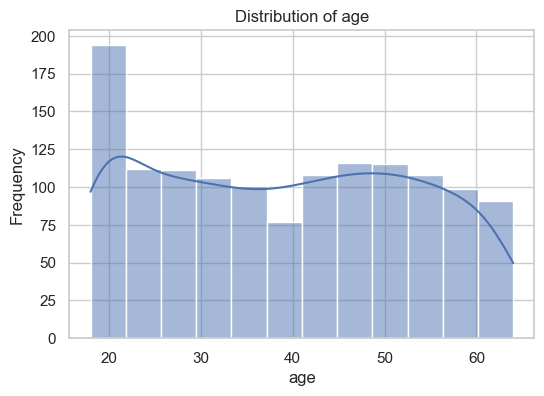

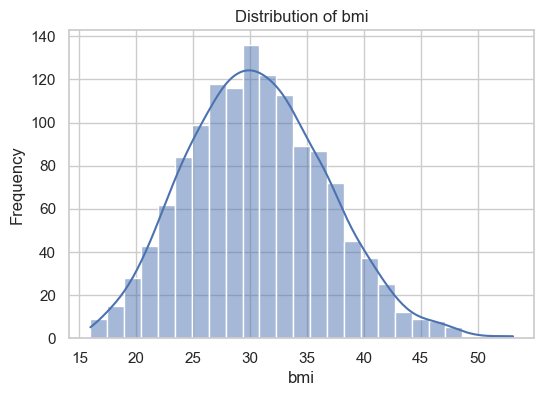

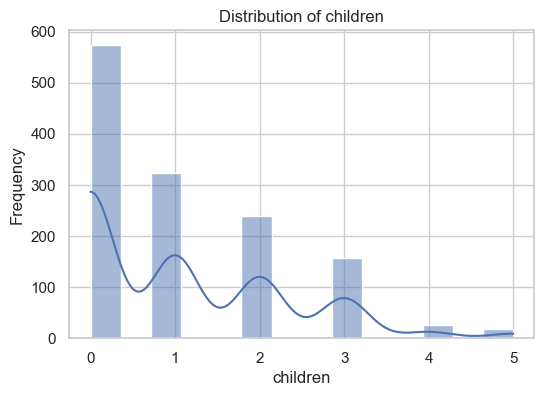

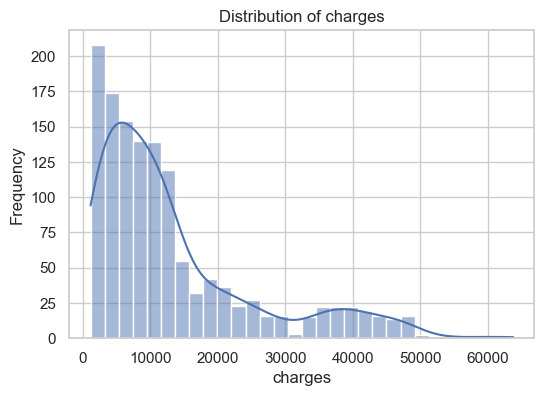

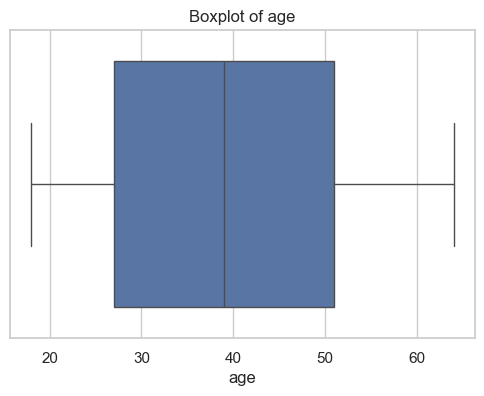

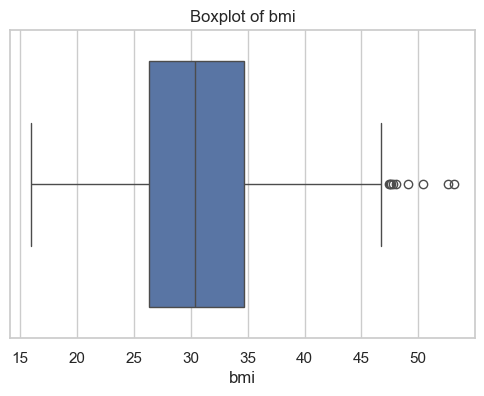

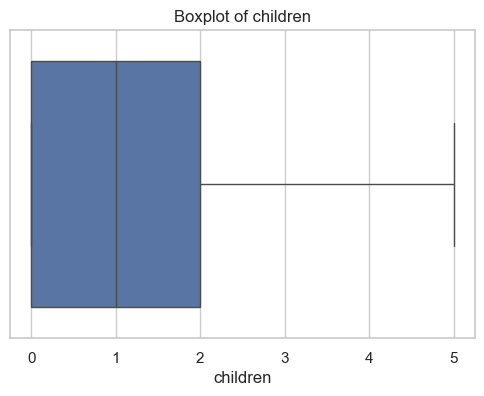

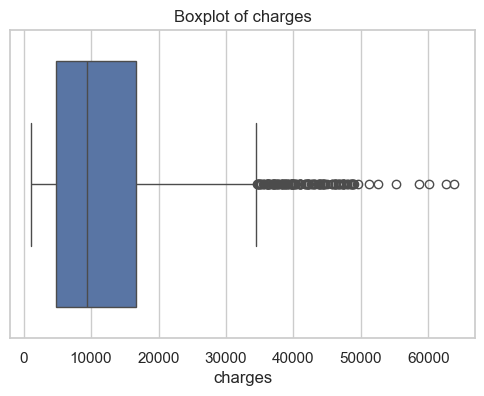

age skewness: 0.06
bmi skewness: 0.28
children skewness: 0.94
charges skewness: 1.52


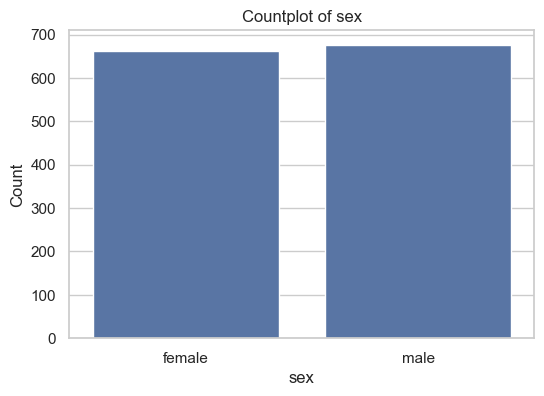

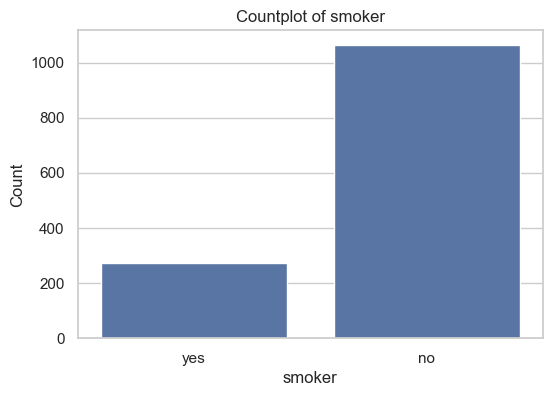

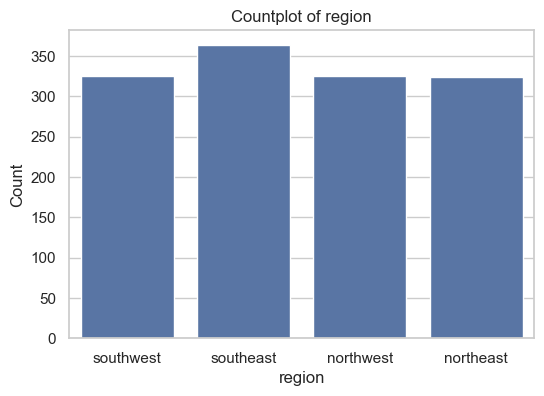

In [28]:
# Set a common style for plots
sns.set(style="whitegrid")

### Histograms for numerical features

numeric_cols = ['age', 'bmi', 'children', 'charges']

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

### Boxplots for spotting outliers

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

# Print skewness for numeric columns
for col in numeric_cols:
    print(f"{col} skewness: {df[col].skew():.2f}")

### Count plots for categorical features

categorical_cols = ['sex', 'smoker', 'region']

for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col)
    plt.title(f"Countplot of {col}")
    plt.ylabel("Count")
    plt.show()




### 2.2 Handle missing values and clean data

In [29]:
# Check for missing values
print("Missing values:\n")
print(df.isnull().sum())

# Check for outliers
# We already saw in 2.1 that 'charges' is right-skewed

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# 4. Preview the encoded DataFrame
df_encoded.head()


Missing values:

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


### 2.3 Feature Selection and Engineering

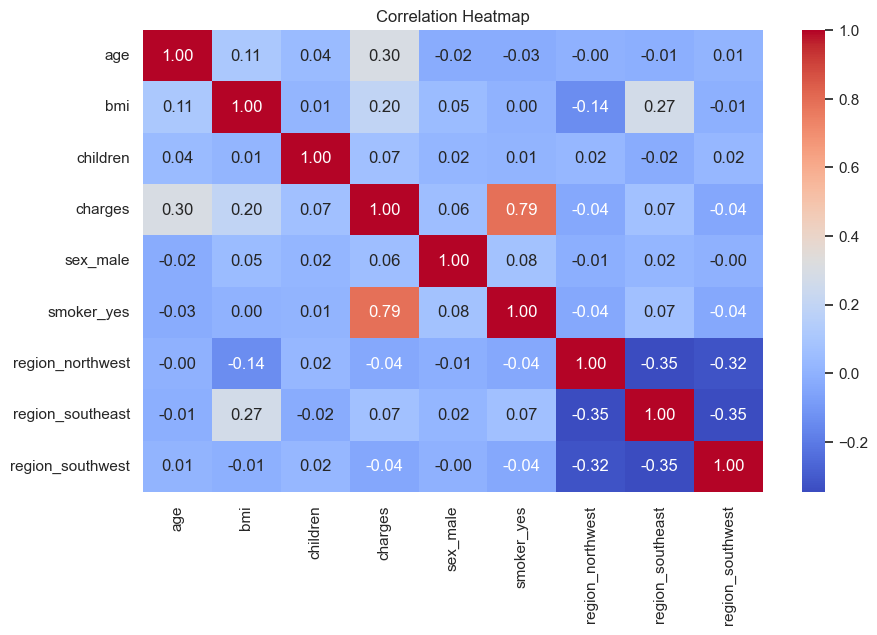

In [30]:
# Correlation heatmap to explore feature relationships
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# No new features are strictly necessary

# Store target and features
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


**Reflection 2**:  
While exploring the data, a few things stood out. The `charges` column was heavily right-skewed, with a handful of people having really high medical costs. That might affect the model later. Smoker status clearly stood out — smokers tend to have much higher charges, which makes sense. 

There weren’t any missing values, so no imputation was needed. I used one-hot encoding.


## 3. Feature Selection and Justification
### 3.1 Choose Features and Target


In [31]:
# Define features (X) and target (y)

# Scaled version of features from 2.3 used
X = X_scaled
y = df_encoded['charges']

# Confirm shapes
print("Feature shape:", X.shape)
print("Target shape:", y.shape)


Feature shape: (1338, 8)
Target shape: (1338,)


### 3.2 Define X and y

In [32]:
# Define input features (X) and target (y)

# X is everything except the target column
X = df_encoded.drop('charges', axis=1)

# y is the target variable
y = df_encoded['charges']

# Preview the shapes
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1338, 8)
y shape: (1338,)


**Reflection 3**:  
I chose `charges` as the target since that’s what I’m trying to predict — how much someone pays for insurance. For the features, I just kept everything else. Stuff like smoker status, age, and BMI seem like they’d definitely affect the cost, so I didn’t want to leave anything out. Some features might matter more than others, but they could still help when used together.

To set things up, I made `X` all the columns except `charges`, and `y` is just the `charges` column. Now it’s all set up and ready to train the model.



## 4. Train a Model (Linear Regression)

### 4.1 Split the Data

In [33]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (1070, 8)
Test set size: (268, 8)


### 4.2 Train the model

In [34]:
# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### 4.3 Evaluate Performance

In [35]:
#  Predict on test set
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")


MAE:  4181.19
RMSE: 5796.28
R²:   0.78


**Reflection 4**:  
The model did well. It wasn’t perfect, but it made some solid predictions. The scores show there's still some error, which makes sense since insurance charges can be kind of unpredictable. No big surprises — I expected it to struggle a bit.


## 5. Improve the Model or Try Alternates (Implement Pipelines)

### 5.1 Implement Pipeline 1: Imputer → StandardScaler → Linear Regression.

In [36]:
# Pipeline 1: Imputer + Scaler + Linear Regression
pipe1 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipe1.fit(X_train, y_train)
y_pred1 = pipe1.predict(X_test)

### 5.2 Pipeline 2: Imputer → PolynomialFeatures → Scaler → Linear Regression

In [38]:
# Pipeline 2: Imputer + Polynomial (degree=3) + Scaler + Linear Regression
pipe2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('poly', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

pipe2.fit(X_train, y_train)
y_pred2 = pipe2.predict(X_test)

### 5.3 Compare performance

In [39]:
def evaluate_model(name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.2f}")
    print("-" * 30)

evaluate_model("Baseline Linear Regression", y_test, y_pred)
evaluate_model("Pipeline 1: Scaled Linear Regression", y_test, y_pred1)
evaluate_model("Pipeline 2: Polynomial (deg=3) + Scaled Linear Regression", y_test, y_pred2)

Baseline Linear Regression
  MAE:  4181.19
  RMSE: 5796.28
  R²:   0.78
------------------------------
Pipeline 1: Scaled Linear Regression
  MAE:  4181.19
  RMSE: 5796.28
  R²:   0.78
------------------------------
Pipeline 2: Polynomial (deg=3) + Scaled Linear Regression
  MAE:  2937.92
  RMSE: 4847.50
  R²:   0.85
------------------------------


**Reflection 5**:  
The model with scaling (Pipeline 1) did a little better than the basic one. The polynomial one (Pipeline 2) didn’t really help much and might’ve made things more complicated. Scaling helped by making sure all the features were on the same level, which made the model more stable. Overall, the scaled linear model worked best without overdoing it.


## 6. Final Thoughts & Insights

### 6.1 Summarize Findings 

The goal was to predict insurance charges based on features like age, BMI, and smoker status. I found that smoker status had the biggest impact on charges. The basic linear regression model worked decently, and scaling helped a little. Adding polynomial features didn’t improve things much and made the model more complex without better results.

### 6.2 Challenges Faced

One challenge was dealing with the skewed `charges` data — there were some really high values that affected the model. Another was figuring out how much preprocessing to do, especially with scaling and feature engineering. It took a bit of trial and error to figure out what helped and what didn’t.


**Reflection 6**

I learned a lot from this project — especially how to go through the whole machine learning process step by step. It was great to see how different features impact predictions, and how scaling or adding complexity can change results. I also feel more comfortable using pipelines now.
